## Probabilistic Matrix Factorization using the MovieLens Dataset

In [1]:
%matplotlib inline
import time

import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import pickle 

from numpy.linalg import inv
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

In [2]:
# Run this when you haven't created a indexed_ratings.csv yet
# Data: https://www.kaggle.com/rounakbanik/the-movies-dataset/download
ratings = pd.read_csv('../data/the-movies-dataset/ratings_small.csv')

# Check the minimum number of ratings a user has posted
print('Minimum number of ratings for each user is ' + str(ratings.groupby('userId').size().min()))
print('Minimum number of ratings for each movie is ' + str(ratings.groupby('movieId').size().min()))

Minimum number of ratings for each user is 20
Minimum number of ratings for each movie is 1


We will only use movies that have more than 4 ratings, to have more training data available per movie.

In [3]:
# We will only use part of the data that has more than 4 reviews per movie
moviecounts = ratings.movieId.value_counts()
ratings = ratings[ratings.movieId.isin(moviecounts.index[moviecounts.gt(4)])].reset_index(drop=True)
print('Minimum number of ratings for each movie is ' + str(ratings.groupby('movieId').size().min()))

Minimum number of ratings for each movie is 5


Since the IDs of the users and movies have gaps in between, we reindex the IDs so that it will be easier to manipulate the user x movie ratings matrix.

In [132]:
# Run this when you DON'T have a indexed_ratings.csv 
# Reindexing of userId and movieId
unique_userId = ratings.userId.unique()
unique_movieId = ratings.movieId.unique()

ratings['new_user_index'], ratings['new_movie_index'] = 0, 0

for old_id, new_id in zip(unique_userId, range(len(unique_userId))):
    ratings['new_user_index'].iloc[ratings[ratings['userId']==old_id].index.tolist()] = new_id

for old_id, new_id in zip(unique_movieId, range(len(unique_movieId))):
    ratings['new_movie_index'].iloc[ratings[ratings['movieId']==old_id].index.tolist()] = new_id

ratings.to_csv('../data/indexed_ratings.csv')

In [4]:
# Run this when you have a indexed_ratings.csv 
ratings = pd.read_csv('../data/indexed_ratings.csv', index_col=0)

In [265]:
# Run this when you DON'T have a imputated_ratings.npy
# Get imputated ratings (put mean rating value of each user as the rating for the missing values)
imputated_ratings = np.empty((ratings.userId.nunique(),ratings.movieId.nunique()))

for user in range(ratings.userId.nunique()):
    user_mean = ratings[ratings.new_user_index == user]['rating'].mean()
    imputated_ratings[user] = user_mean
    for column in ratings[ratings.new_user_index == user]['new_movie_index']:
        imputated_ratings[user, column] = ratings[(ratings.new_user_index == user)&(ratings.new_movie_index == column)]['rating']  

np.save('../data/imputated_ratings.npy', imputated_ratings)

added user row 0: [2.5  3.   3.   ... 2.55 2.55 2.55]
added user row 1: [3.48684211 3.48684211 3.48684211 ... 3.48684211 3.48684211 3.48684211]
added user row 2: [3.54166667 3.54166667 3.54166667 ... 3.54166667 3.54166667 3.54166667]
added user row 3: [4.37688442 4.37688442 4.37688442 ... 4.37688442 4.37688442 4.37688442]
added user row 4: [3.91 3.91 3.91 ... 3.91 3.91 3.91]
added user row 5: [3.26136364 3.26136364 3.26136364 ... 3.26136364 3.26136364 3.26136364]
added user row 6: [3.         3.46590909 3.46590909 ... 3.46590909 3.46590909 3.46590909]
added user row 7: [3.89380531 3.89380531 3.89380531 ... 3.89380531 3.89380531 3.89380531]
added user row 8: [3.75555556 3.75555556 3.75555556 ... 3.75555556 3.75555556 3.75555556]
added user row 9: [3.68181818 3.68181818 3.68181818 ... 3.68181818 3.68181818 3.68181818]
added user row 10: [4.05882353 4.05882353 4.05882353 ... 4.05882353 4.05882353 4.05882353]
added user row 11: [2.75 2.75 2.75 ... 2.75 2.75 2.75]
added user row 12: [3.7452

added user row 98: [3.43243243 3.         3.43243243 ... 3.43243243 3.43243243 3.43243243]
added user row 99: [3.4 3.4 3.4 ... 3.4 3.4 3.4]
added user row 100: [3.89622642 3.89622642 3.89622642 ... 3.89622642 3.89622642 3.89622642]
added user row 101: [3.99685039 5.         2.         ... 3.99685039 3.99685039 3.99685039]
added user row 102: [3.43678161 3.43678161 3.43678161 ... 3.43678161 3.43678161 3.43678161]
added user row 103: [4.06 4.06 4.06 ... 4.06 4.06 4.06]
added user row 104: [3.36409736 3.36409736 4.         ... 3.36409736 3.36409736 3.36409736]
added user row 105: [3.81578947 3.81578947 3.81578947 ... 3.81578947 3.81578947 3.81578947]
added user row 106: [2.859375 2.859375 2.859375 ... 2.859375 2.859375 2.859375]
added user row 107: [3.4516129 3.4516129 3.4516129 ... 3.4516129 3.4516129 3.4516129]
added user row 108: [4.10869565 4.10869565 4.10869565 ... 4.10869565 4.10869565 4.10869565]
added user row 109: [4.         4.15833333 4.15833333 ... 4.15833333 4.15833333 4.1583

added user row 196: [4.09677419 4.09677419 4.09677419 ... 4.09677419 4.09677419 4.09677419]
added user row 197: [3.7739726 3.7739726 3.7739726 ... 3.7739726 3.7739726 3.7739726]
added user row 198: [3.73976608 3.73976608 3.73976608 ... 3.73976608 3.73976608 3.73976608]
added user row 199: [3.26724138 3.26724138 3.26724138 ... 3.26724138 3.26724138 3.26724138]
added user row 200: [4.1637931 4.1637931 4.1637931 ... 4.1637931 4.1637931 4.1637931]
added user row 201: [3.83050847 3.83050847 3.83050847 ... 3.83050847 3.83050847 3.83050847]
added user row 202: [4. 4. 4. ... 4. 4. 4.]
added user row 203: [3.33333333 3.33333333 3.33333333 ... 3.33333333 3.33333333 3.33333333]
added user row 204: [3.40979381 3.40979381 3.40979381 ... 3.40979381 3.40979381 3.40979381]
added user row 205: [3.41025641 3.41025641 3.41025641 ... 3.41025641 3.41025641 3.41025641]
added user row 206: [2. 2. 2. ... 2. 2. 2.]
added user row 207: [4.0326087 4.0326087 4.0326087 ... 4.0326087 4.0326087 4.0326087]
added user

added user row 291: [3.95220588 3.95220588 4.         ... 3.95220588 3.95220588 3.95220588]
added user row 292: [3.47368421 3.47368421 3.47368421 ... 3.47368421 3.47368421 3.47368421]
added user row 293: [3.58582575 3.         3.58582575 ... 3.58582575 3.58582575 3.58582575]
added user row 294: [3.9845815 3.9845815 3.9845815 ... 3.9845815 3.9845815 3.9845815]
added user row 295: [3.94736842 3.94736842 3.94736842 ... 3.94736842 3.94736842 3.94736842]
added user row 296: [3.6259542 3.6259542 3.6259542 ... 3.6259542 3.6259542 3.6259542]
added user row 297: [4.76271186 4.76271186 4.76271186 ... 4.76271186 4.76271186 4.76271186]
added user row 298: [4.14508929 4.14508929 4.14508929 ... 4.14508929 4.14508929 4.14508929]
added user row 299: [4.05681818 4.05681818 4.05681818 ... 4.05681818 4.05681818 4.05681818]
added user row 300: [3.41304348 3.41304348 3.41304348 ... 3.41304348 3.41304348 3.41304348]
added user row 301: [3.34285714 3.34285714 3.34285714 ... 3.34285714 3.34285714 3.34285714]


added user row 386: [4.23715415 5.         4.23715415 ... 4.23715415 4.23715415 4.23715415]
added user row 387: [3.67887324 3.67887324 3.67887324 ... 3.67887324 3.67887324 3.67887324]
added user row 388: [3.46938776 3.46938776 3.46938776 ... 3.46938776 3.46938776 3.46938776]
added user row 389: [3.29166667 3.29166667 3.29166667 ... 3.29166667 3.29166667 3.29166667]
added user row 390: [3.74545455 3.74545455 3.74545455 ... 3.74545455 3.74545455 3.74545455]
added user row 391: [3.08695652 3.08695652 3.08695652 ... 3.08695652 3.08695652 3.08695652]
added user row 392: [3.11956522 3.11956522 3.11956522 ... 3.11956522 3.11956522 3.11956522]
added user row 393: [2.         3.32312925 3.32312925 ... 3.32312925 3.32312925 3.32312925]
added user row 394: [3.2173913 3.2173913 3.2173913 ... 3.2173913 3.2173913 3.2173913]
added user row 395: [3.26277372 3.26277372 3.26277372 ... 3.26277372 3.26277372 3.26277372]
added user row 396: [3.61 3.61 3.61 ... 3.61 3.61 3.61]
added user row 397: [4.0196078

added user row 485: [3.59848485 3.59848485 3.59848485 ... 3.59848485 3.59848485 3.59848485]
added user row 486: [5.         3.77333333 3.77333333 ... 3.77333333 3.77333333 3.77333333]
added user row 487: [4.09803922 4.09803922 4.09803922 ... 4.09803922 4.09803922 4.09803922]
added user row 488: [3.875 3.875 3.875 ... 3.875 3.875 3.875]
added user row 489: [3.54545455 3.54545455 3.54545455 ... 3.54545455 3.54545455 3.54545455]
added user row 490: [3.55 3.55 3.55 ... 3.55 3.55 3.55]
added user row 491: [3.67307692 3.67307692 3.67307692 ... 3.67307692 3.67307692 4.        ]
added user row 492: [3.54716981 3.54716981 3.54716981 ... 3.54716981 3.54716981 3.54716981]
added user row 493: [4.01282051 4.01282051 4.01282051 ... 4.01282051 4.01282051 4.01282051]
added user row 494: [4.08 4.08 4.08 ... 4.08 4.08 4.08]
added user row 495: [4.         3.91869919 3.91869919 ... 3.91869919 3.91869919 3.91869919]
added user row 496: [3.82352941 3.82352941 3.82352941 ... 3.82352941 3.82352941 3.82352941

added user row 581: [3.5610687 4.        3.5610687 ... 3.5610687 3.5610687 3.5610687]
added user row 582: [4.15 4.15 4.15 ... 4.15 4.15 4.15]
added user row 583: [3.8150289 3.8150289 4.5       ... 3.8150289 3.8150289 3.8150289]
added user row 584: [4.26736111 4.26736111 4.26736111 ... 4.26736111 4.26736111 4.26736111]
added user row 585: [3.39285714 3.39285714 3.39285714 ... 3.39285714 3.39285714 3.39285714]
added user row 586: [4.06818182 4.06818182 4.06818182 ... 4.06818182 4.06818182 4.        ]
added user row 587: [3.67307692 3.67307692 3.67307692 ... 3.67307692 3.67307692 3.67307692]
added user row 588: [3.60465116 3.60465116 3.60465116 ... 3.60465116 3.60465116 3.60465116]
added user row 589: [3.         3.48314607 3.48314607 ... 3.48314607 3.48314607 3.48314607]
added user row 590: [3.23333333 3.23333333 3.23333333 ... 3.23333333 3.23333333 3.23333333]
added user row 591: [3.90151515 3.90151515 3.90151515 ... 3.90151515 3.90151515 3.90151515]
added user row 592: [3.94285714 3.94

In [5]:
# Run this when you have a imputated_ratings.npy
imputated_ratings = np.load('../data/imputated_ratings.npy')

In [6]:
imputated_ratings

array([[2.5       , 3.        , 3.        , ..., 2.55      , 2.55      ,
        2.55      ],
       [3.48684211, 3.48684211, 3.48684211, ..., 3.48684211, 3.48684211,
        3.48684211],
       [3.54166667, 3.54166667, 3.54166667, ..., 3.54166667, 3.54166667,
        3.54166667],
       ...,
       [3.42857143, 3.42857143, 3.42857143, ..., 3.42857143, 3.42857143,
        3.42857143],
       [3.80645161, 3.80645161, 3.80645161, ..., 3.80645161, 3.80645161,
        3.80645161],
       [3.92982456, 3.92982456, 3.92982456, ..., 3.92982456, 3.92982456,
        3.92982456]])

We split randomly the data into train and test data. Specifically, we take 5 random ratings out of each user's rating list, creating 5 x (num of users) ratings in the test set. The remaining data becomes the training set.

In [7]:
# Randomly split the data into train and test
# Specifically, take 5 random ratings out from each user's rating list (therefore, there will be 5 times # of user ratings in the test set)
# For each user id, take out 5 ratings oaut of the dataframe then append them into a new dataframe.
# Then take the difference of the two data frames and the difference will be the train data
for userid in ratings.userId.unique() :
    if userid == 1:
        test_ratings = ratings[ratings['userId']==userid].sample(5, random_state=0)
    else:
        test_ratings = test_ratings.append(ratings[ratings['userId']==userid].sample(5, random_state=0))
train_ratings = pd.concat([ratings, test_ratings]).drop_duplicates(keep=False).reset_index(drop=True)
test_ratings = test_ratings.reset_index(drop=True)
print("Number of ratings in entire dataset is "+ str(len(ratings)))
print("Number of ratings in train dataset is "+  str(len(train_ratings)))
print("Number of ratings in test dataset is "+ str(len(test_ratings)))

Number of ratings in entire dataset is 90072
Number of ratings in train dataset is 86717
Number of ratings in test dataset is 3355


Distribution of All Ratings (with more than 4 reviews)

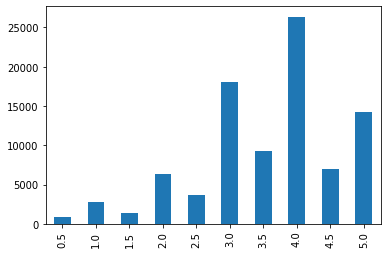

In [8]:
# Distribution of All Ratings (with more than 4 reviews)
ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

Distribution of Train Data Ratings

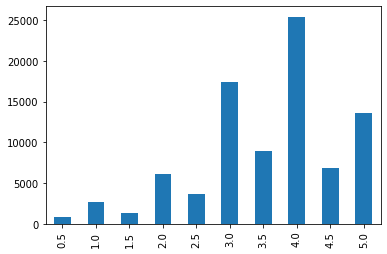

In [9]:
# Distribution of Train Datxa Ratings
train_ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

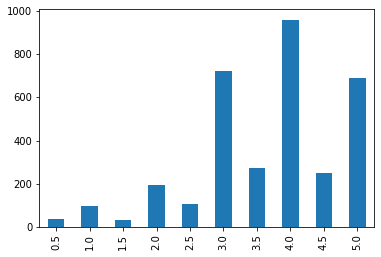

In [10]:
# Distribution of Test Data Ratings
test_ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

Now we implement the Probabilistic Matrix Factorization (PMF) model, and train the model using the train dataset. In our case, PMF 's objective is to fill in the missing values of the movie matrix $M$, by maximizing the following MAP objective function.

$L = - \Sigma_{(i,j)\in \Omega}\frac{1}{2\sigma^2}(M_{ij}-u_i^Tv_j)^2-\Sigma_{i=1}^{N_u}\frac{\lambda}{2}||u_i||^2-\Sigma_{j=1}^{N_v}\frac{\lambda}{2}||v_j||^2$,

where $u_i$ is the $i$th user vector, $v_j$ the $j$th movie vector, $N_u$ the number of users, $N_v$ the number of movies, $\Omega$ the set of $(i,j)$s that have a rating in the matrix $M$, $\sigma^2$ the variance of $M_{ij} \sim N(u_i^Tv_j, \sigma^2)$. Therefore, each rating in $M$ are assumed to be normally distributed. Also, note that the each user vector $u_i$ and movie vector $v_j$ are initialized from the distribution $N(0, \lambda^{-1}I)$, where $u$ is a $i \times k$ matrix and $v$ is a $j \times k$ matrix.

We have implemented the model below.

In [232]:
# Reference: https://sandipanweb.wordpress.com/2017/04/04/probabilistic-matrix-factorization-with-a-generative-model-in-python/
# Implementation of Probabilistic Matrix Factorization from the above reference
class PMF:
    def __init__(self, k, prior_mean=0, prior_std=1, epochs=20):
        self.k = k
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        self.epochs = epochs
        self.u = None
        self.v = None
        self.M_prime = None

    def fit(self, data):
        ratings = data
        self.I = ratings.userId.nunique()
        self.J = ratings.movieId.nunique()
        self.u = pyro.sample("user_factor", dist.Normal(self.prior_mean, self.prior_std), sample_shape=torch.Size([self.I,self.k]))
        self.v = pyro.sample("movie_factor", dist.Normal(self.prior_mean, self.prior_std), sample_shape=torch.Size([self.J,self.k]))
        self.data_var = ratings['rating'].var(axis=0)
        
        user_to_movie_dict = {}
        movie_to_user_dict = {}

        for i in range(self.I):
            user_to_movie_dict[i] = ratings[ratings['new_user_index']==i]['new_movie_index'].tolist()
        for j in range(self.J):
            movie_to_user_dict[j] = ratings[ratings['new_movie_index']==j]['new_user_index'].tolist()
            
        for epoch_num in range(self.epochs):
            # Update of all u_i: Took 110.703 seconds on Yuki's cp
            for i in range(len(self.u)):
                v_sum = 0
                mv_sum = 0
                for j in user_to_movie_dict[i]:
                    v_sum += np.outer(self.v[j],self.v[j])
                    mv_sum += float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) * self.v[j]
                self.u[i] = torch.from_numpy(np.dot(inv(self.prior_std * self.data_var * np.identity(self.k) + v_sum), mv_sum))

            # Update of all v_j: Took 106.218 seconds on Yuki's cp
            for j in range(len(self.v)):
                u_sum = 0
                mu_sum = 0
                for i in movie_to_user_dict[j]:
                    u_sum += np.outer(self.u[i],self.u[i])
                    mu_sum += float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) * self.u[i]
                self.v[j] = torch.from_numpy(np.dot(inv(self.prior_std * self.data_var * np.identity(self.k) + u_sum), mu_sum))

            self.M_prime = torch.mm(self.u,self.v.T)
            error = 0
            for i in range(len(self.u)):
                for j in user_to_movie_dict[i]:
                    error += (float(ratings[(ratings['new_user_index']==i) & (ratings['new_movie_index']==j)].rating) - self.M_prime[i][j])**2
            print('MSE of Epoch ' + str(epoch_num) + ': ' + str(float(error/len(ratings))))

In [352]:
# Implementation of Probabilistic Matrix Factorization using Pyro
# (To use Pyro, need data that has missing values imputated with the mean rating of each user)
def model(data, k=10):
    with pyro.plate('users', ratings.userId.nunique()):
        u = pyro.sample('u', dist.MultivariateNormal(torch.zeros(k), 1*torch.eye(k)))
    with pyro.plate('movies', ratings.movieId.nunique()):
        v = pyro.sample('v', dist.MultivariateNormal(torch.zeros(k), 1*torch.eye(k)))
    r = pyro.sample("obs", dist.Normal(torch.mm(u,v.T), 1), obs=data)

In [75]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4) 
mcmc = MCMC(kernel, num_samples=20, warmup_steps=10)
mcmc.run(torch.tensor(imputated_ratings))
posterior_samples = mcmc.get_samples()

warmup:  17%|█▋        | 5/30 [00:15,  4.13s/it, step size=9.26e-05, acc. prob=0.222]

KeyboardInterrupt: 

We train the PMF using $k=10$ and 20 epochs.

In [340]:
for i in range(20):
    print(torch.mm(posterior_samples['u'][i,:,:], posterior_samples['v'][i,:,:].T))

tensor([[-0.1102,  0.1566, -0.0534,  ...,  0.0308, -0.4149,  0.0186],
        [-0.2528,  0.0758,  0.0544,  ..., -0.0391, -0.5624, -0.0513],
        [ 0.0246,  0.4325, -0.0412,  ..., -0.0727, -0.5107,  0.0611],
        ...,
        [-0.2492,  0.3677, -0.0090,  ...,  0.2730, -0.2320, -0.0878],
        [-0.5274,  0.1095,  0.1545,  ...,  0.2048, -0.3804, -0.1647],
        [-0.1709,  0.5437, -0.1872,  ...,  0.1844, -0.6101, -0.0777]])
tensor([[-0.1132,  0.1532, -0.0508,  ...,  0.0298, -0.4141,  0.0173],
        [-0.2522,  0.0709,  0.0562,  ..., -0.0415, -0.5626, -0.0542],
        [ 0.0229,  0.4311, -0.0362,  ..., -0.0765, -0.5126,  0.0634],
        ...,
        [-0.2531,  0.3644, -0.0044,  ...,  0.2701, -0.2308, -0.0881],
        [-0.5268,  0.1150,  0.1559,  ...,  0.2050, -0.3801, -0.1643],
        [-0.1693,  0.5440, -0.1864,  ...,  0.1820, -0.6131, -0.0754]])
tensor([[-0.1156,  0.1555, -0.0516,  ...,  0.0331, -0.4120,  0.0164],
        [-0.2531,  0.0734,  0.0557,  ..., -0.0438, -0.5619, -0

In [91]:
# Bayesian PMF using Pyro
# (To use Pyro, need data that has missing values imputated with the mean rating of each user)
def model(data, k=10):
    with pyro.plate('users', ratings.userId.nunique()):
        with pyro.plate('user_k', k):
            p_u_mu = pyro.sample('p_u_mu', dist.Normal(0, 1))
            p_u_std = pyro.sample('p_u_std', dist.InverseGamma(1,1))
            u = pyro.sample('u', dist.Normal(p_u_mu, p_u_std))
    with pyro.plate('movies', ratings.movieId.nunique()):
        with pyro.plate('movie_k', k):
            p_v_mu = pyro.sample('p_v_mu', dist.Normal(0, 1))^
            p_v_std = pyro.sample('p_v_std', dist.InverseGamma(1,1))
            v = pyro.sample('v', dist.Normal(p_v_mu, p_v_std))
    pyro.sample("obs", dist.Normal(torch.mm(u.T,v), 1), obs=data)

In [92]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4) 
mcmc = MCMC(kernel, num_samples=10, warmup_steps=10)
mcmc.run(torch.tensor(imputated_ratings))
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 20/20 [2:48:53, 506.66s/it, step size=5.63e-04, acc. prob=0.996] 


In [93]:
for i in range(20):
    print(torch.mm(posterior_samples['u'][i,:,:].T, posterior_samples['v'][i,:,:]))

tensor([[2.3029, 2.4651, 2.4868,  ..., 2.5887, 2.5663, 2.3533],
        [3.3412, 3.3986, 3.3926,  ..., 3.6275, 3.5851, 3.3799],
        [3.4369, 3.5039, 3.4332,  ..., 3.4393, 3.4725, 3.5267],
        ...,
        [3.5590, 3.4406, 3.3744,  ..., 3.5505, 3.7082, 3.5446],
        [3.4984, 3.6270, 3.6563,  ..., 3.7577, 3.8291, 3.7109],
        [3.7372, 3.8025, 3.8838,  ..., 3.9798, 3.9851, 3.7709]])
tensor([[2.4011, 2.3720, 2.4927,  ..., 2.6303, 2.6012, 2.3554],
        [3.3772, 3.2635, 3.2776,  ..., 3.6247, 3.5881, 3.3386],
        [3.5613, 3.4494, 3.3188,  ..., 3.4706, 3.5390, 3.5943],
        ...,
        [3.6740, 3.2794, 3.3714,  ..., 3.6051, 3.8133, 3.4710],
        [3.6811, 3.5201, 3.6110,  ..., 3.7385, 3.8826, 3.7058],
        [3.8184, 3.6962, 3.7234,  ..., 3.9700, 4.0543, 3.7989]])
tensor([[2.4499, 2.2800, 2.3513,  ..., 2.6307, 2.7042, 2.6310],
        [3.3629, 3.2972, 3.3076,  ..., 3.5633, 3.5035, 3.5457],
        [3.4161, 3.3211, 3.3332,  ..., 3.5078, 3.4640, 3.3594],
        ...,

IndexError: index 10 is out of bounds for dimension 0 with size 10

In [106]:
tensor =  torch.mm(posterior_samples['u'][0,:,:].T, posterior_samples['v'][0,:,:])
tensor

tensor([[2.3029, 2.4651, 2.4868,  ..., 2.5887, 2.5663, 2.3533],
        [3.3412, 3.3986, 3.3926,  ..., 3.6275, 3.5851, 3.3799],
        [3.4369, 3.5039, 3.4332,  ..., 3.4393, 3.4725, 3.5267],
        ...,
        [3.5590, 3.4406, 3.3744,  ..., 3.5505, 3.7082, 3.5446],
        [3.4984, 3.6270, 3.6563,  ..., 3.7577, 3.8291, 3.7109],
        [3.7372, 3.8025, 3.8838,  ..., 3.9798, 3.9851, 3.7709]])

In [110]:
tensor =  torch.mm(posterior_samples['u'][1,:,:].T, posterior_samples['v'][1,:,:])
for i in range(0,10):
    tensor += torch.mm(posterior_samples['u'][i,:,:].T, posterior_samples['v'][i,:,:])
tensor = tensor/10

In [111]:
rounded_estimate_ratings = (tensor* 2).round()/ 2
rounded_estimate_ratings[rounded_estimate_ratings>5.0] = 5.0
rounded_estimate_ratings[rounded_estimate_ratings<0.5] = 0.5
print(rounded_estimate_ratings)

tensor([[2.5000, 2.5000, 3.0000,  ..., 3.0000, 3.0000, 3.0000],
        [4.0000, 4.0000, 4.0000,  ..., 4.0000, 4.0000, 4.0000],
        [4.0000, 4.0000, 4.0000,  ..., 4.0000, 4.0000, 4.0000],
        ...,
        [4.0000, 3.5000, 3.5000,  ..., 4.0000, 4.0000, 4.0000],
        [4.0000, 4.0000, 4.0000,  ..., 4.0000, 4.0000, 4.0000],
        [4.5000, 4.5000, 4.0000,  ..., 4.5000, 4.5000, 4.5000]])


In [112]:
rounded_estimate_ratings_unique = rounded_estimate_ratings.unique(sorted=True)
rounded_estimate_ratings_counts = torch.stack([(rounded_estimate_ratings==rounded_estimate).sum() for  rounded_estimate in rounded_estimate_ratings_unique])
rounded_estimate_ratings_counts

tensor([  3402,     94,   2845,  18616, 139351, 424485, 924562, 673669, 158792])

<BarContainer object of 9 artists>

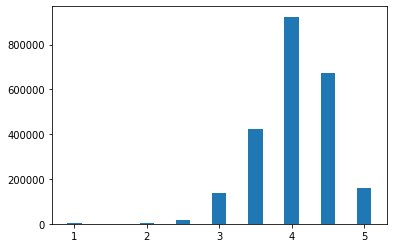

In [113]:
plt.bar(rounded_estimate_ratings_unique, rounded_estimate_ratings_counts, width=0.2)

In [54]:
rounded_estimate_ratings = (torch.mm(posterior_samples['u'][19,:,:].T,posterior_samples['v'][19,:,:] )* 2).round()/ 2
rounded_estimate_ratings[rounded_estimate_ratings>5.0] = 5.0
rounded_estimate_ratings[rounded_estimate_ratings<0.5] = 0.5
print(rounded_estimate_ratings)

tensor([[2.5000, 2.5000, 2.5000,  ..., 2.5000, 2.5000, 2.5000],
        [3.5000, 3.5000, 3.5000,  ..., 3.5000, 3.5000, 3.5000],
        [3.5000, 3.5000, 3.5000,  ..., 3.5000, 3.5000, 3.5000],
        ...,
        [3.5000, 3.5000, 3.5000,  ..., 3.5000, 3.5000, 3.5000],
        [3.5000, 4.0000, 4.0000,  ..., 4.0000, 4.0000, 4.0000],
        [4.0000, 4.0000, 4.0000,  ..., 4.0000, 4.0000, 4.0000]])


In [55]:
rounded_estimate_ratings_unique = rounded_estimate_ratings.unique(sorted=True)
rounded_estimate_ratings_counts = torch.stack([(rounded_estimate_ratings==rounded_estimate).sum() for  rounded_estimate in rounded_estimate_ratings_unique])
rounded_estimate_ratings_counts

tensor([  3496,   7412,  59837, 256948, 824123, 883796, 290684,  19520])

<BarContainer object of 8 artists>

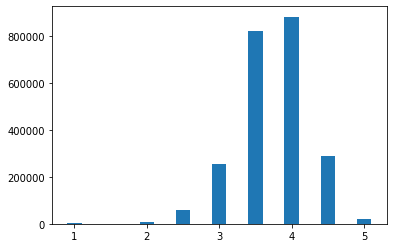

In [56]:
plt.bar(rounded_estimate_ratings_unique, rounded_estimate_ratings_counts, width=0.2)

In [28]:
for i in range(20):
    print(torch.mm(posterior_samples['u'][i,:,:], posterior_samples['v'][i,:,:].T))

RuntimeError: size mismatch, m1: [10 x 671], m2: [3496 x 10] at ../aten/src/TH/generic/THTensorMath.cpp:197

In [198]:
# Fit the PMF model with 
model_k10_e20 = PMF(10)
model_k10_e20.fit(train_ratings)

MSE of Epoch 0: 5.537270545959473
MSE of Epoch 1: 0.6590448021888733
MSE of Epoch 2: 0.49050578474998474
MSE of Epoch 3: 0.43283361196517944
MSE of Epoch 4: 0.4021185636520386
MSE of Epoch 5: 0.3824620842933655
MSE of Epoch 6: 0.36833488941192627
MSE of Epoch 7: 0.3574390113353729
MSE of Epoch 8: 0.34870439767837524
MSE of Epoch 9: 0.341552197933197
MSE of Epoch 10: 0.3356055021286011
MSE of Epoch 11: 0.33060985803604126
MSE of Epoch 12: 0.32640382647514343
MSE of Epoch 13: 0.3228400945663452
MSE of Epoch 14: 0.31979066133499146
MSE of Epoch 15: 0.3171609938144684
MSE of Epoch 16: 0.31487900018692017
MSE of Epoch 17: 0.3128867745399475
MSE of Epoch 18: 0.3111385405063629
MSE of Epoch 19: 0.309597909450531


Retrieving the predicted $M^{\prime}$ with the fill missing values, 

In [199]:
# After the training, retrive the estimated user-movie rating matrix
estimate_ratings = model_k10_e20.M_prime

In [227]:
# Round the estimated ratings to the closest .5 rating between 0.5 and 5
rounded_estimate_ratings = (estimate_ratings * 2).round()/ 2
rounded_estimate_ratings[rounded_estimate_ratings>5.0] = 5.0
rounded_estimate_ratings[rounded_estimate_ratings<0.5] = 0.5
print(rounded_estimate_ratings)

tensor([[2.5000, 2.5000, 2.5000,  ..., 2.0000, 1.0000, 1.0000],
        [3.5000, 3.5000, 3.5000,  ..., 2.0000, 1.5000, 2.0000],
        [3.0000, 2.5000, 3.5000,  ..., 2.5000, 1.5000, 1.5000],
        ...,
        [3.0000, 3.5000, 3.5000,  ..., 3.0000, 2.0000, 2.0000],
        [3.5000, 3.0000, 3.5000,  ..., 2.5000, 2.5000, 1.5000],
        [3.5000, 3.5000, 3.5000,  ..., 1.5000, 1.5000, 2.5000]])


Using Posterior Predictive Check (PPC) to criticize this model, 

In [223]:
# PPC 
# get distribution of ratings from the entire data, and for each user
# get distribution of ratings from the predicted entire data, and predictions for each user
# check if the discrepancies are close to each other

# Discrepancies of original data
# Max and min ratings are trivially the same
mean_rating = train_ratings['rating'].mean()
median_rating = train_ratings['rating'].median()
first_q_rating = np.quantile(train_ratings['rating'],0.25)
third_q_rating = np.quantile(train_ratings['rating'],0.75)

# Discrepancies of trained_data
pred_mean_rating = torch.mean(rounded_estimate_ratings)
pred_median_rating = torch.median(rounded_estimate_ratings)
pred_first_q_rating = np.quantile(rounded_estimate_ratings.numpy(),0.25)
pred_third_q_rating = np.quantile(rounded_estimate_ratings.numpy(),0.75)

print('Discrepancy of mean ratings: ' + str(mean_rating - pred_mean_rating))
print('Discrepancy of median ratings: ' + str(median_rating - pred_median_rating))
print('Discrepancy of first_q ratings: ' + str(first_q_rating - pred_first_q_rating))
print('Discrepancy of third_q ratings: ' + str(third_q_rating - pred_third_q_rating))

Discrepancy of mean ratings: tensor(0.7257)
Discrepancy of median ratings: tensor(1.)
Discrepancy of first_q ratings: 1.0
Discrepancy of third_q ratings: 0.5


We compared the distribution of the train data ratings with the predicted $M^{\prime}$ ratings. The discrepancies of the distributions are big considering that the values of ratings are between 0.5~5, which means that the PMF model is not performing well. This is trivial when you compare the two distributions visually.

Distribution of ratings in the predicted $M^{\prime}$

In [208]:
rounded_estimate_ratings_unique = rounded_estimate_ratings.unique(sorted=True)
rounded_estimate_ratings_counts = torch.stack([(rounded_estimate_ratings==rounded_estimate).sum() for  rounded_estimate in rounded_estimate_ratings_unique])
rounded_estimate_ratings_counts

tensor([ 73889,  93566, 180108, 291417, 395507, 447349, 406005, 276485, 129591,
         51899])

<BarContainer object of 10 artists>

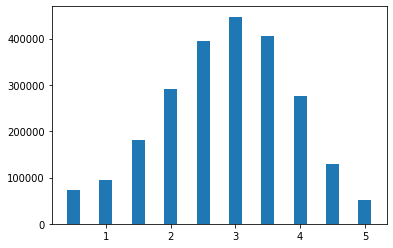

In [230]:
plt.bar(rounded_estimate_ratings_unique, rounded_estimate_ratings_counts, width=0.2)

Distribution of Train Data Ratings

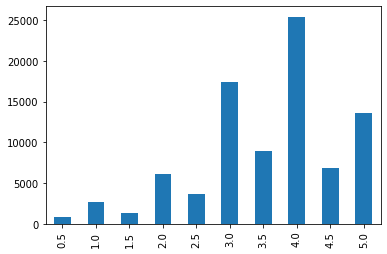

In [231]:
train_ratings['rating'].value_counts().reindex([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]).plot(kind='bar')

It seems like the predicted data is distributed normally, due to the fact that the PMF assumes a normal distribution on its ratings, and the variance of each ratings are the same. Therefore, there seems to be space for improvement.

In [6]:
# POP-PC
# Cross validation POP-PC
# Randomly remove ratings from train data, and keep possession of them to check later on 
# Train the model, then compare the entire data distribution and the ratings distributions of each user.

In [213]:
# Save trained model
with open('10k20epochPMF.pkl', 'wb') as output:
    pickle.dump(model_k10_e20, output, pickle.HIGHEST_PROTOCOL)